# Risk Model for Credit Loan Default Prediction

## Importing Necessary Libraries and Loading Data


In [172]:
import numpy as np
import pandas as pd
import os

In [173]:
os.listdir('../../datasets/husainsb/lendingclub-issued-loans')

['lc_2016_2017.csv', 'lc_loan.csv', 'us-state-codes.csv', 'new.html']

## 1. Load the data

In [174]:
df_data = pd.read_csv('../../datasets/husainsb/lendingclub-issued-loans/lc_2016_2017.csv')

/var/folders/86/0ktjtbzj13b2z0b54356w3h00000gn/T/ipykernel_5928/590291582.py:1: DtypeWarning: Columns (18,54) have mixed types. Specify dtype option on import or set low_memory=False.
  df_data = pd.read_csv('../../datasets/husainsb/lendingclub-issued-loans/lc_2016_2017.csv')


In [175]:
df_data.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,112435993,NaN,2300,2300,2300.0,36 months,12.62,77.08,C,C1,...,0.0,NaN,1.0,2.0,2315.0,55.0,7100.0,1.0,0.0,2.0
1,112290210,NaN,16000,16000,16000.0,60 months,12.62,360.95,C,C1,...,11078.0,69.0,3.0,5.0,1962.0,94.0,31900.0,0.0,6.0,1.0
2,112436985,NaN,6025,6025,6025.0,36 months,15.05,209.01,C,C4,...,0.0,NaN,1.0,2.0,1950.0,45.0,27700.0,1.0,5.0,3.0
3,112439006,NaN,20400,20400,20400.0,36 months,9.44,652.91,B,B1,...,53566.0,95.0,1.0,2.0,4240.0,60.0,46900.0,1.0,1.0,1.0
4,112438929,NaN,13000,13000,13000.0,36 months,11.99,431.73,B,B5,...,8466.0,72.0,0.0,1.0,2996.0,78.0,7800.0,0.0,0.0,0.0


In [176]:
df_data.shape

(759338, 72)

In [177]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 759338 entries, 0 to 759337
Data columns (total 72 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           759338 non-null  int64  
 1   member_id                    0 non-null       float64
 2   loan_amnt                    759338 non-null  int64  
 3   funded_amnt                  759338 non-null  int64  
 4   funded_amnt_inv              759338 non-null  float64
 5   term                         759338 non-null  object 
 6   int_rate                     759338 non-null  float64
 7   installment                  759338 non-null  float64
 8   grade                        759338 non-null  object 
 9   sub_grade                    759338 non-null  object 
 10  emp_title                    708368 non-null  object 
 11  emp_length                   708975 non-null  object 
 12  home_ownership               759338 non-null  object 
 13 

In [178]:
df_data.loan_status.value_counts()

loan_status
Current               565523
Fully Paid            130718
Charged Off            37197
Late (31-120 days)     15354
In Grace Period         6634
Late (16-30 days)       3876
Default                   36
Name: count, dtype: int64

## 2. Creating the good_bad Column
In this section, we create a new column, good_bad, in the df_data DataFrame to categorize loans as either good or bad based on their status:

Good loan (0): The loan is considered "good" if the loan status is one of the following:
    - Fully Paid
    - Current
    - In Grace Period
Bad loan (1): The loan is considered "bad" if the loan status is one of the following:
    - Charged Off
    - Default
    - Late (31-120 days)
    - Late (16-30 days)
    
We use the apply() function along with a lambda function to apply this classification rule to each row's loan_status value. The result is stored in the new good_bad column, where 0 represents a good loan and 1 represents a bad loan.

In [179]:
# create good_bad column
# 0: good loan
# 1: bad loan
# 
# bad loan: Charged Off, Default, Late (31-120 days), Late (16-30 days)
# good loan: Fully Paid, Current, In Grace Period
df_data['good_bad'] = df_data.loan_status.apply(lambda x: 0 if x in ['Fully Paid', 'Current', 'In Grace Period'] else 1)


In [180]:
df_data.good_bad.value_counts()

good_bad
0    702875
1     56463
Name: count, dtype: int64

In [181]:
show_columns = ['loan_status', 'good_bad']
df_data[show_columns]

,loan_status,good_bad
0,Current,0
1,Current,0
2,Current,0
3,Current,0
4,Current,0
...,...,...
759333,Current,0
759334,Current,0
759335,Late (16-30 days),1
759336,Current,0


## 3. Handling Missing Values
In this section, we calculate the percentage of missing values for each column in the dataset.

In [182]:
missing_value = pd.DataFrame(df_data.isnull().sum()/df_data.shape[0]*100, columns=['missing %'])
missing_value

,missing %
id,0.000000
member_id,100.000000
loan_amnt,0.000000
funded_amnt,0.000000
funded_amnt_inv,0.000000
...,...
total_rev_hi_lim,0.000000
inq_fi,0.008033
total_cu_tl,0.008165
inq_last_12m,0.008165


In [183]:
missing_value = missing_value[missing_value['missing %'] > 50]
missing_value.sort_values(by='missing %', ascending=False)
missing_value

,missing %
member_id,100.000000
desc,99.997761
mths_since_last_record,81.407621
mths_since_last_major_derog,71.672035
annual_inc_joint,95.522020
dti_joint,95.522284
verification_status_joint,95.522020


## 4. Data Preprocessing

Dropping Columns with Excessive Missing Values
In this step, we drop columns from the dataset that have more than 50% missing values. 

In [184]:
df_data.dropna(axis=1, thresh=df_data.shape[0]*0.5, inplace=True)

In [185]:
missing_value = pd.DataFrame(df_data.isnull().sum()/df_data.shape[0]*100, columns=['missing %'])
missing_value = missing_value[missing_value['missing %'] > 50]
missing_value = missing_value.sort_values(by='missing %', ascending=False)
missing_value

,missing %


In [186]:
df_data.shape

(759338, 66)

## 5. Data Splitting

Splitting the Data into Training and Testing Sets
Here, 20% of the data is reserved for testing, and the remaining 80% is used for training. The random_state=42 ensures reproducibility of the split.

In [187]:
# splitting  data into 80 % training data and 20% testing data 
from sklearn.model_selection import train_test_split

In [188]:
x = df_data.drop('good_bad', axis=1)
y = df_data['good_bad']

In [189]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [190]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((607470, 65), (151868, 65), (607470,), (151868,))

In [191]:
y_train.value_counts(normalize=True)

good_bad
0    0.925512
1    0.074488
Name: proportion, dtype: float64

Data highly imbalanced, with 92.5% of the data labeled as good loans and only 7.5% labeled as bad loans.

In [192]:
y_test.value_counts(normalize=True)

good_bad
0    0.92616
1    0.07384
Name: proportion, dtype: float64

## 6. Data Cleaning
Inspecting Unique Values in Categorical Columns

In [193]:
for col in x_train.select_dtypes(include=['object', 'category', 'bool']).columns: 
    print(f'{col}: {x_train[col].unique()}')

term: ['60 months' '36 months']
grade: ['E' 'C' 'B' 'A' 'D' 'G' 'F']
sub_grade: ['E4' 'C5' 'C4' 'C1' 'B5' 'A4' 'C2' 'B1' 'B3' 'A2' 'D2' 'B4' 'A1' 'E1'
 'A5' 'B2' 'G2' 'D4' 'C3' 'D5' 'E5' 'A3' 'G3' 'D3' 'F2' 'F1' 'D1' 'E2'
 'F4' 'G4' 'F5' 'E3' 'G1' 'G5' 'F3']
emp_title: ['QC' 'Seo Analyst' 'Teacher/administration' ...
 'Registered Nurse Inpatient Care Manager' 'Application Development Mgr'
 'Sales Coordinator/Customer Service']
emp_length: ['4 years' '< 1 year' '10+ years' '3 years' '1 year' '6 years' '8 years'
 '7 years' '9 years' nan '2 years' '5 years']
home_ownership: ['MORTGAGE' 'RENT' 'OWN' 'ANY' 'NONE']
verification_status: ['Source Verified' 'Not Verified' 'Verified']
issue_d: ['Nov-2016' 'Jan-2016' 'May-2016' 'May-2017' 'Jul-2016' 'Mar-2016'
 'Jan-2017' 'Sep-2016' 'Feb-2017' 'Jul-2017' 'Sep-2017' 'Jun-2016'
 'Aug-2016' 'Jun-2017' 'Aug-2017' 'Apr-2016' 'Dec-2016' 'Apr-2017'
 'Feb-2016' 'Oct-2016' 'Mar-2017']
loan_status: ['Current' 'Late (31-120 days)' 'Fully Paid' 'Charged Off'

In [194]:
columns_need_to_clean = ['term', 'emp_length', 'issue_d', 'earliest_cr_line', 'revol_util', 'initial_list_status', 'last_pymnt_d', 'last_credit_pull_d']

### Cleaning Categorical Columns

In [195]:
x_train['term'].value_counts()

term
36 months    449330
60 months    158140
Name: count, dtype: int64

In [196]:
x_train['term'] = x_train['term'].str.extract('(\d+)')
x_test['term'] = x_test['term'].str.extract('(\d+)')

In [197]:
x_train['term'] = pd.to_numeric(x_train['term'])
x_test['term'] = pd.to_numeric(x_test['term'])

In [198]:
x_train['emp_length'].value_counts()

emp_length
10+ years    206066
2 years       55739
< 1 year      50176
3 years       48584
1 year        40524
5 years       36949
4 years       36458
6 years       26061
8 years       23002
9 years       22845
7 years       20561
Name: count, dtype: int64

In [199]:
# replace < 1 year with 0
x_train['emp_length'] = x_train['emp_length'].str.replace('< 1 year', '0')
x_train['emp_length'] = x_train['emp_length'].str.extract('(\d+)')

x_test['emp_length'] = x_test['emp_length'].str.replace('< 1 year', '0')
x_test['emp_length'] = x_test['emp_length'].str.extract('(\d+)')

In [200]:
x_train['emp_length'] = pd.to_numeric(x_train['emp_length'])
x_test['emp_length'] = pd.to_numeric(x_test['emp_length'])
x_train['emp_length'].value_counts()

emp_length
10.0    206066
2.0      55739
0.0      50176
3.0      48584
1.0      40524
5.0      36949
4.0      36458
6.0      26061
8.0      23002
9.0      22845
7.0      20561
Name: count, dtype: int64

### Filling Missing Values
filling missing values in the emp_length column with 0

In [201]:
# check missing emp_length
x_train['emp_length'].isnull().sum()

np.int64(40505)

In [202]:
# fill missing value with 0
x_train['emp_length'].fillna(0, inplace=True)
x_test['emp_length'].fillna(0, inplace=True)
x_train['emp_length'].isnull().sum()

/var/folders/86/0ktjtbzj13b2z0b54356w3h00000gn/T/ipykernel_5928/446331516.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  x_train['emp_length'].fillna(0, inplace=True)
/var/folders/86/0ktjtbzj13b2z0b54356w3h00000gn/T/ipykernel_5928/446331516.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always beha

np.int64(0)

In [203]:
x_train['issue_d'].head()

575893    Nov-2016
748895    Jan-2016
482512    May-2016
572425    Nov-2016
71962     May-2017
Name: issue_d, dtype: object

In [204]:
columns_date = ['issue_d', 'earliest_cr_line', 'last_pymnt_d', 'last_credit_pull_d']
x_train[columns_date].head()

,issue_d,earliest_cr_line,last_pymnt_d,last_credit_pull_d
575893,Nov-2016,Jun-2005,Dec-2017,Dec-2017
748895,Jan-2016,Sep-2007,Oct-2017,Dec-2017
482512,May-2016,Sep-1992,Sep-2017,Nov-2017
572425,Nov-2016,Sep-1975,Dec-2017,Dec-2017
71962,May-2017,Sep-2012,Dec-2017,Dec-2017


In [205]:
# convert to datetime
for col in columns_date:
    x_train[col] = pd.to_datetime(x_train[col])
    x_test[col] = pd.to_datetime(x_test[col])

x_train[columns_date].head()

/var/folders/86/0ktjtbzj13b2z0b54356w3h00000gn/T/ipykernel_5928/772438817.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  x_train[col] = pd.to_datetime(x_train[col])
/var/folders/86/0ktjtbzj13b2z0b54356w3h00000gn/T/ipykernel_5928/772438817.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  x_test[col] = pd.to_datetime(x_test[col])
/var/folders/86/0ktjtbzj13b2z0b54356w3h00000gn/T/ipykernel_5928/772438817.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  x_train[col] = pd.to_datetime(x_train[col])
/var/folders/86/0ktjtbzj13b2z0b54356w3h00000gn/T/ipykernel_5928/77243881

,issue_d,earliest_cr_line,last_pymnt_d,last_credit_pull_d
575893,2016-11-01,2005-06-01,2017-12-01,2017-12-01
748895,2016-01-01,2007-09-01,2017-10-01,2017-12-01
482512,2016-05-01,1992-09-01,2017-09-01,2017-11-01
572425,2016-11-01,1975-09-01,2017-12-01,2017-12-01
71962,2017-05-01,2012-09-01,2017-12-01,2017-12-01


In [206]:
x_train[columns_need_to_clean].info()

<class 'pandas.core.frame.DataFrame'>
Index: 607470 entries, 575893 to 121958
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   term                 607470 non-null  int64         
 1   emp_length           607470 non-null  float64       
 2   issue_d              607470 non-null  datetime64[ns]
 3   earliest_cr_line     607470 non-null  datetime64[ns]
 4   revol_util           607060 non-null  float64       
 5   initial_list_status  607470 non-null  object        
 6   last_pymnt_d         606701 non-null  datetime64[ns]
 7   last_credit_pull_d   607459 non-null  datetime64[ns]
dtypes: datetime64[ns](4), float64(2), int64(1), object(1)
memory usage: 41.7+ MB


In [207]:
x_test[columns_need_to_clean].info()

<class 'pandas.core.frame.DataFrame'>
Index: 151868 entries, 179093 to 510769
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   term                 151868 non-null  int64         
 1   emp_length           151868 non-null  float64       
 2   issue_d              151868 non-null  datetime64[ns]
 3   earliest_cr_line     151868 non-null  datetime64[ns]
 4   revol_util           151761 non-null  float64       
 5   initial_list_status  151868 non-null  object        
 6   last_pymnt_d         151689 non-null  datetime64[ns]
 7   last_credit_pull_d   151861 non-null  datetime64[ns]
dtypes: datetime64[ns](4), float64(2), int64(1), object(1)
memory usage: 10.4+ MB


In [208]:
x_train = x_train[columns_need_to_clean]
x_test = x_test[columns_need_to_clean]

x_train.head()

,term,emp_length,issue_d,earliest_cr_line,revol_util,initial_list_status,last_pymnt_d,last_credit_pull_d
575893,60,4.0,2016-11-01,2005-06-01,20.6,w,2017-12-01,2017-12-01
748895,60,0.0,2016-01-01,2007-09-01,33.4,w,2017-10-01,2017-12-01
482512,60,10.0,2016-05-01,1992-09-01,63.4,f,2017-09-01,2017-11-01
572425,60,10.0,2016-11-01,1975-09-01,56.0,w,2017-12-01,2017-12-01
71962,36,3.0,2017-05-01,2012-09-01,31.1,w,2017-12-01,2017-12-01


In [209]:
del x_train['initial_list_status']
del x_test['initial_list_status']


In [210]:
# convert term to float
x_train['term'] = x_train['term'].astype(float)
x_test['term'] = x_test['term'].astype(float)
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 607470 entries, 575893 to 121958
Data columns (total 7 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   term                607470 non-null  float64       
 1   emp_length          607470 non-null  float64       
 2   issue_d             607470 non-null  datetime64[ns]
 3   earliest_cr_line    607470 non-null  datetime64[ns]
 4   revol_util          607060 non-null  float64       
 5   last_pymnt_d        606701 non-null  datetime64[ns]
 6   last_credit_pull_d  607459 non-null  datetime64[ns]
dtypes: datetime64[ns](4), float64(3)
memory usage: 37.1 MB


### Handling Date Columns and Calculating Date Differences

In [211]:
from datetime import datetime
today = datetime.today().strftime('%Y-%m-%d')
today

'2024-12-11'

In [212]:
# for all date columns, calculate the difference between today and the date

for col in columns_date:
    x_train[col] = (pd.to_datetime(today) - x_train[col]).dt.days
    x_test[col] = (pd.to_datetime(today) - x_test[col]).dt.days
    


In [213]:
# and convert date column to float type
x_train[columns_date] = x_train[columns_date].astype(float)

In [214]:
x_test[columns_date] = x_test[columns_date].astype(float)
x_train.head()

,term,emp_length,issue_d,earliest_cr_line,revol_util,last_pymnt_d,last_credit_pull_d
575893,60.0,4.0,2962.0,7133.0,20.6,2567.0,2567.0
748895,60.0,0.0,3267.0,6311.0,33.4,2628.0,2567.0
482512,60.0,10.0,3146.0,11789.0,63.4,2658.0,2597.0
572425,60.0,10.0,2962.0,17999.0,56.0,2567.0,2567.0
71962,36.0,3.0,2781.0,4484.0,31.1,2567.0,2567.0


In [215]:
x_test.head()

,term,emp_length,issue_d,earliest_cr_line,revol_util,last_pymnt_d,last_credit_pull_d
179093,36.0,3.0,2901.0,11698.0,29.3,2567.0,2567.0
391394,36.0,9.0,2720.0,6615.0,59.8,2567.0,2567.0
370873,36.0,10.0,2689.0,7681.0,65.3,2567.0,2567.0
269295,36.0,1.0,3085.0,10572.0,73.1,2597.0,2567.0
5441,36.0,9.0,2750.0,11271.0,6.7,2567.0,2567.0


### Handling missing values with median

In [216]:
x_train.isnull().sum()

term                    0
emp_length              0
issue_d                 0
earliest_cr_line        0
revol_util            410
last_pymnt_d          769
last_credit_pull_d     11
dtype: int64

In [217]:
x_test.isnull().sum()

term                    0
emp_length              0
issue_d                 0
earliest_cr_line        0
revol_util            107
last_pymnt_d          179
last_credit_pull_d      7
dtype: int64

In [218]:
x_train.fillna(x_train.median(), inplace=True)
x_test.fillna(x_test.median(), inplace=True)

In [219]:
x_train.isnull().sum()

term                  0
emp_length            0
issue_d               0
earliest_cr_line      0
revol_util            0
last_pymnt_d          0
last_credit_pull_d    0
dtype: int64

In [220]:
x_test.isnull().sum()

term                  0
emp_length            0
issue_d               0
earliest_cr_line      0
revol_util            0
last_pymnt_d          0
last_credit_pull_d    0
dtype: int64

## 7. Model Building

For binary classification always start from Logistic Regression.

In [221]:
from sklearn.linear_model import LogisticRegression


In [222]:
model = LogisticRegression()

In [223]:
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

/Users/jankristantowibisono/miniconda3/envs/data-science-exploration/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [224]:
result = pd.DataFrame({'y_pred': y_pred, 'y_test': y_test})

In [225]:
result.head()

,y_pred,y_test
179093,0,0
391394,0,0
370873,0,0
269295,0,0
5441,0,0


## 8. Model Evaluation
The accuracy score is a metric used to evaluate the performance of classification models. It measures the proportion of correct predictions made by the model. It is calculated as:

Accuracy = Number of Correct Predictions / Total Number of Predictions


In [226]:
from sklearn.metrics import accuracy_score

In [227]:
accuracy_score(y_test, y_pred)

0.9175204783101114

A confusion matrix is a summary table used to assess the performance of a classification algorithm. It compares the predicted labels against the actual labels (ground truth). For binary classification (e.g., good vs. bad loans), the confusion matrix contains four values:

True Positive (TP): The number of instances correctly predicted as positive (bad loans correctly classified as bad).
True Negative (TN): The number of instances correctly predicted as negative (good loans correctly classified as good).
False Positive (FP): The number of instances incorrectly predicted as positive (good loans incorrectly classified as bad).
False Negative (FN): The number of instances incorrectly predicted as negative (bad loans incorrectly classified as good).

In [228]:
from sklearn.metrics import confusion_matrix
import matplotlib_inline as plt
import seaborn as sns

In [229]:
cm = confusion_matrix(y_test, y_pred)

<Axes: >

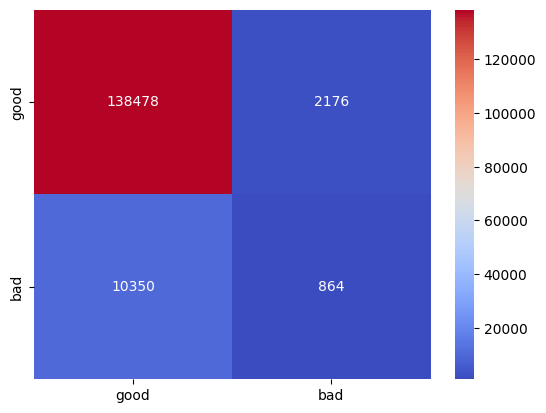

In [230]:
sns.heatmap(cm, annot=True, fmt='.0f', cmap='coolwarm', xticklabels=['good', 'bad'], yticklabels=['good', 'bad'])

Imbalanced Binary Classification

In [231]:
y_train.value_counts(normalize=True)

good_bad
0    0.925512
1    0.074488
Name: proportion, dtype: float64

### Handling Imbalanced Data

In [232]:
model.predict_proba(x_test)

array([[0.96743468, 0.03256532],
       [0.95463411, 0.04536589],
       [0.95650076, 0.04349924],
       ...,
       [0.83890461, 0.16109539],
       [0.95698477, 0.04301523],
       [0.94592211, 0.05407789]], shape=(151868, 2))

Receiver Operating Characteristic (ROC) curve for evaluating the classification performance at different threshold values

In [233]:
from sklearn.metrics import roc_curve
fp, tp, thresholds = roc_curve(y_test, model.predict_proba(x_test)[:, 1])

In [234]:
thresholds

array([           inf, 9.65898386e-01, 9.50362208e-01, ...,
       1.65088386e-04, 1.58934736e-04, 4.86786790e-05], shape=(14782,))

### Youden's J Statistic for Optimizing the Threshold
We use Youden's J statistic to determine the optimal threshold for classification. Youden's J statistic is a measure that combines sensitivity (recall) and specificity into a single value to help optimize the classification threshold. 

In [235]:
# youden j statistic
youden_j = tp - fp
ix = np.argmax(youden_j)
best_threshold = thresholds[ix]

In [236]:
best_threshold

np.float64(0.06829410163156237)

Youden's J statistic is particularly useful for imbalanced datasets because it optimizes the balance between false positives and false negatives, making it a great choice for choosing a threshold in classification problems. By maximizing Youden's J, we aim to achieve the highest possible combined accuracy of detecting both positive and negative cases without bias toward the majority class.

In [237]:
y_pred = np.where(model.predict_proba(x_test)[:, 1] > best_threshold, 1, 0)

In [238]:
y_pred

array([0, 0, 0, ..., 1, 0, 0], shape=(151868,))

<Axes: >

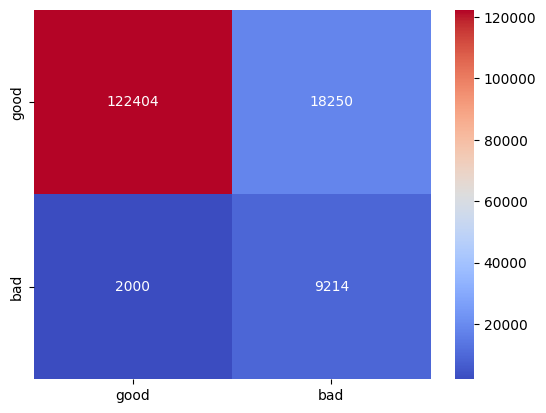

In [239]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='.0f', cmap='coolwarm', xticklabels=['good', 'bad'], yticklabels=['good', 'bad'])


In [240]:
model.coef_

array([[ 1.29465028e-02, -6.23845297e-03,  3.92279420e-04,
        -5.41245952e-05,  5.84099773e-03,  8.46958751e-03,
        -1.02282766e-02]])

### Interpreting the Coefficients:
- Positive coefficients suggest that as the feature value increases, the likelihood of the predicted class (e.g., bad loan) increases.
- Negative coefficients suggest that as the feature value increases, the likelihood of the predicted class (e.g., bad loan) decreases.
- Magnitude: The larger the magnitude of a coefficient (positive or negative), the more impact that feature has on the prediction.

- This is helpful in understanding which features are driving the model’s predictions and can guide further feature engineering or interpretation of model behavior.

In [241]:
df_coef = pd.DataFrame({'feature': x_train.columns, 'coef': model.coef_[0]})
df_coef

,feature,coef
0,term,0.012947
1,emp_length,-0.006238
2,issue_d,0.000392
3,earliest_cr_line,-0.000054
4,revol_util,0.005841
5,last_pymnt_d,0.008470
6,last_credit_pull_d,-0.010228


### Understanding the Coefficients:
#### term (Coefficient = 0.012947):

A positive coefficient means that as the loan term (the length of the loan) increases, the likelihood of the loan being classified as a bad loan increases, though the effect is small since the coefficient is relatively small.
#### emp_length (Coefficient = -0.006238):

A negative coefficient indicates that as the borrower's employment length increases, the likelihood of the loan being classified as bad decreases. Longer employment might suggest more financial stability, which lowers the risk of default.
#### issue_d (Coefficient = 0.000392):

The coefficient is positive, meaning that as the issue date of the loan increases (i.e., as time goes on), the likelihood of the loan being classified as bad increases slightly. This effect could be related to external factors affecting newer loans or a temporal trend in loan defaults.
#### earliest_cr_line (Coefficient = -0.000054):

A negative coefficient suggests that as the borrower's earliest credit line date (i.e., how long they've had credit) gets later, the likelihood of the loan being classified as bad decreases. This could mean that borrowers with a longer history of credit might be less likely to default.
#### revol_util (Coefficient = 0.005841):

The positive coefficient indicates that as the borrower's revolving credit utilization rate increases (i.e., how much of their available credit they are using), the likelihood of the loan being classified as bad increases. High credit utilization is often associated with higher credit risk, which makes this feature quite intuitive.
#### last_pymnt_d (Coefficient = 0.008470):

A positive coefficient suggests that the more recent the last payment date, the higher the likelihood of the loan being classified as bad. This might suggest that more recent payments could be indicative of late or insufficient payments.
#### last_credit_pull_d (Coefficient = -0.010228):

A negative coefficient indicates that as the time since the last credit pull (a check on the borrower's credit history) increases, the likelihood of the loan being classified as bad decreases. This could suggest that a recent credit pull might be linked to financial distress or other negative factors.

### Interpretation of the Results:
Positive coefficients (like term, issue_d, revol_util, and last_pymnt_d) suggest that an increase in these features makes the loan more likely to be classified as a bad loan (1). For example, higher credit utilization (revol_util) and more recent loan issue dates (issue_d) correlate with a higher risk of default.

Negative coefficients (like emp_length, earliest_cr_line, and last_credit_pull_d) suggest that an increase in these features makes the loan more likely to be classified as a good loan (0). For example, longer employment history (emp_length) and a more distant earliest credit line date (earliest_cr_line) reduce the likelihood of a bad loan.